In [1]:

!git clone https://github.com/miguel-fc/Neutron_Reflect.git

fatal: destination path 'Neutron_Reflect' already exists and is not an empty directory.


In [2]:
cd Neutron_Reflect/

/pscratch/sd/q/qubri000/Neutron_Reflect


In [3]:
pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install gdown

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install -U --no-cache-dir gdown --pre

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import numpy as np
import data_preparation as dpre
import io
import os
# import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
import seaborn as sea

In [9]:
class CNN(nn.Module):
    def __init__(self, num_layers):
        super(CNN, self).__init__()
        self.layers = nn.ModuleList()
        addition = 255/num_layers
        curr = 1
        for hdim in range(num_layers-1):
            self.layers.append(nn.Conv1d(int(curr+0.5), int(curr+addition+0.5),51,padding=25))
            self.layers.append(nn.BatchNorm1d(int(curr+addition+0.5)))
            self.layers.append(nn.ReLU(True))
            curr += addition
        self.layers.append(nn.Conv1d(int(curr+0.5), 256, 51, padding=25))
        
#         self.conv1 = nn.Conv1d(1,13,51,padding=25)
#         self.batch1 = nn.BatchNorm1d(13)
#         self.relu1 = nn.ReLU(True)
        
#         self.conv2 = nn.Conv1d(13,25,51,padding=25)
#         self.batch2 = nn.BatchNorm1d(25)
#         self.relu2 = nn.ReLU(True)
        
#         self.conv3 = nn.Conv1d(25,38,51,padding=25)
#         self.batch3 = nn.BatchNorm1d(38)
#         self.relu3 = nn.ReLU(True)
        
#         self.conv4 = nn.Conv1d(38,50,51,padding=25) 
#         self.batch4 = nn.BatchNorm1d(50)
#         self.relu4 = nn.ReLU(True)
        
#         self.conv5 = nn.Conv1d(50,64,51,padding=25) 
#         self.batch5 = nn.BatchNorm1d(64)
#         self.relu5 = nn.ReLU(True)
        
        self.linear1 = nn.Linear(256*308,900*2)
        # self.linear2 = nn.Linear(120*308,2*308)
        # self.linear2 = nn.Linear(33*308, 2*308)
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        # x = self.batch5(x)
        # x = self.relu5(x)
        # print(x.shape)
        x = x.reshape(x.shape[0], -1)
        x = self.linear1(x)
        # x = self.linear2(x)
        # x = self.linear2(x)
        x = x.reshape(-1, 2, 900)
        # print(x.shape)
        return torch.sigmoid(x)

In [10]:
## Training function
def fit(Model, device, dataloader, loss_fn, optim):
    Model.train().to(device)
    train_loss = []
    for data,label in dataloader:
        img = data
        img = img.to(device)
        label = label.to(device)
        decoded_img = Model(img)
        # print(decoded_img.shape)
        # decoded_img = decoded_img.reshape(-1,2, 308)
        loss = loss_fn(decoded_img, label)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss.append(loss.cpu().detach().numpy())
        # print(label, "hello")
    return np.mean(train_loss)

In [11]:
### Valid function
def val(Model, device, dataloader, loss_fn):
    Model.eval().to(device)
    with torch.no_grad(): 
        list_decoded_img = []
        list_img = []
        for  data, label in dataloader:
            img = data
            # img = img.view(img.size(0), -1).to(device) 
            # img = img[:,np.newaxis,:].to(device) 
            img = img.to(device) 
            label = label.to(device)
            decoded_img = Model(img)
            # decoded_img = decoded_img.reshape(-1,2, 308)
            list_decoded_img.append(decoded_img.cpu())
            list_img.append(label.cpu())
        list_decoded_img = torch.cat(list_decoded_img)
        list_img = torch.cat(list_img)
        # print(list_img, list_decoded_img, "vaLLLLL FUNCTION")
#         for i in range(len(list_img)):
            
        val_loss = loss_fn(list_decoded_img, list_img)
    return val_loss.data

In [12]:
def plot_outputs(Model,dataset,device,n=10):
  print(max_valX, min_valX)
  plt.figure(figsize=(26,5.5))
  for i in range(n):
    ax = plt.subplot(2,n,i+1)
    img, label =dataset[i]
    img = img[:,np.newaxis,:].to(device) 
    #Notice that below i'm loading an image only, so it needs to be flatten
    #before entering the network
    # img = torch.flatten(img).to(device)
    # print(label[0], "hello")
    # print(img.shape)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(img)
      # decoded_img = decoded_img.reshape(-1,2, 308)
      # loss = loss_fn(decoded_img,label)
      # print('For image {}, the loss = {}'.format(i,loss.data))
    # print(label)
    # print(label.shape)
    plt.plot(label[0], label[1]) 
    if i == n//2:
      ax.set_title('Original images')
    ax = plt.subplot(2, n, i + 1 + n)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    plt.plot(decoded_img.cpu()[0][0], decoded_img.cpu()[0][1]) 
    if i == n//2:
      ax.set_title('Reconstructed images')
  plt.show()  

In [ ]:
#finding global normalization numbers for NR Curves
import os
directory = "../"
totalDataY = []
totalDataX = []
count = 0
for i,filename in enumerate(os.listdir(directory)):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f[-3:] == "npy" and f[3:5] == "NR":
        print(f[3:])
        NRCurveY = np.load(f)[:,1]
        NRCurveX = np.load(f)[:,0]
        NRCurveY = np.log10(NRCurveY)
        NRCurveX = np.log10(NRCurveX)
        for j in range(len(NRCurveX)):
            totalDataY.append(NRCurveY[j])
            totalDataX.append(NRCurveX[j])
        # totalDataY.append(NRCurveY)
        # totalDataX.append(NRCurveX)
min_valXNR = float('inf')
max_valXNR = -float('inf')
min_valYNR = float('inf')
max_valYNR = -float('inf')
totalDataY = np.array(totalDataY)
totalDataX = np.array(totalDataX)
# print(totalDataY.shape)
for i in range(len(totalDataY)):
    min_valXNR = min(min(totalDataX[i]), min_valXNR)
    min_valYNR = min(min(totalDataY[i]), min_valYNR)
    max_valXNR = max(max(totalDataX[i]), max_valXNR)
    max_valYNR = max(max(totalDataY[i]), max_valYNR)
# for i in range(len(totalDataY)):
#     for j in range(len(totalDataY[0])):
#         totalDataX[i][j] -= min_valXNR
#         totalDataY[i][j] -= min_valYNR
#         totalDataX[i][j] /= (max_valXNR - min_valXNR)
#         totalDataY[i][j] /= (max_valYNR - min_valYNR)
np.save("../NRRanges100000", [min_valXNR, max_valXNR, min_valYNR, max_valYNR])

In [13]:
#finding global normalization numbers for NR Curves
import os
directory = "../"
totalDataY = []
totalDataX = []
count = 0
min_valXSLD = float('inf')
max_valXSLD = -float('inf')
min_valYSLD = float('inf')
max_valYSLD = -float('inf')
for i,filename in enumerate(os.listdir(directory)):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f[-3:] == "npy" and f[3:6] == "SLD" and f[6:12] != "Ranges":
        print(f[3:])
        # SLDCurveY = np.log10(SLDCurveY)
        # SLDCurveX = np.log10(SLDCurveX)
        # for j in range(900):
        file = np.load(f)
        for j in range(len(file)):
            # print(file[i].shape)
            min_valXSLD = min(min_valXSLD, min(file[j][0]))
            max_valXSLD = max(max_valXSLD, max(file[j][0]))
            min_valYSLD = min(min_valYSLD, min(file[j][1]))
            max_valYSLD = max(max_valYSLD, max(file[j][1]))
        # totalDataY.append(NRCurveY)
        # totalDataX.append(NRCurveX)

# totalDataY = np.array(totalDataY)
# totalDataX = np.array(totalDataX)
# print(totalDataY.shape)
print([min_valXSLD, max_valXSLD, min_valYSLD, max_valYSLD])
np.save("../SLDRanges100000", [min_valXSLD, max_valXSLD, min_valYSLD, max_valYSLD])

SLD_CurvesPoly12.npy
SLD_CurvesPoly11.npy
SLD_CurvesPoly15.npy
SLD_CurvesPoly22.npy
SLD_CurvesPoly34.npy
SLD_CurvesPoly23.npy
SLD_CurvesPoly41.npy
SLD_CurvesPoly33.npy
SLD_CurvesPoly24.npy
SLD_CurvesPoly31.npy
SLD_CurvesPoly21.npy
SLD_CurvesPoly44.npy
SLD_CurvesPoly35.npy
SLD_CurvesPoly42.npy
SLD_CurvesPoly51.npy
SLD_CurvesPoly54.npy
SLD_CurvesPoly13.npy
SLD_CurvesPoly52.npy
SLD_CurvesPoly55.npy
SLD_CurvesPoly32.npy
SLD_CurvesPoly43.npy
SLD_CurvesPoly25.npy
SLD_CurvesPoly53.npy
SLD_CurvesPoly14.npy
SLD_CurvesPoly45.npy
[0.0, 780.4999999999973, -2.0588982065310035, 7.026778406383315]


0.0 780.4999999999973 -2.0588982065310035 7.026778406383315
1 1


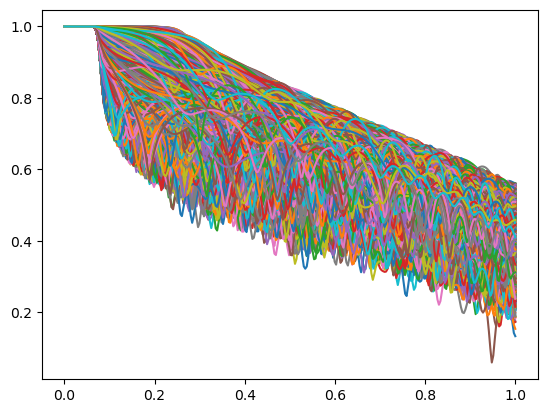

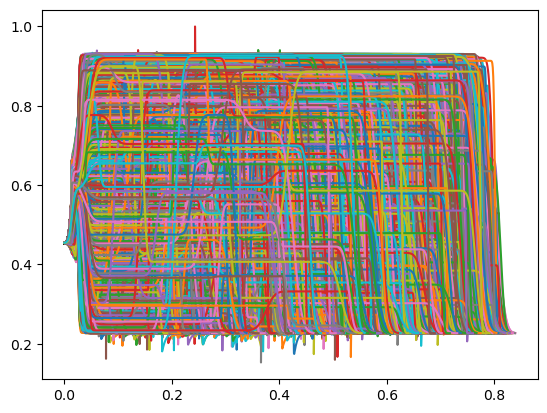

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(90000, 1, 308) (90000, 2, 900) (5000, 1, 308) (5000, 2, 900) (5000, 1, 308) (5000, 2, 900)


In [ ]:
from copy import deepcopy
count = 0
for first in range(1,6):
    for second in range(1,6):
        # print(first, second, count)
        count += 1

        # if count <=4:
        #     continue
        ### Define the loss function
        with open('../SLDRanges100000.npy', 'rb') as f:
            min_valXSLD, max_valXSLD, min_valYSLD, max_valYSLD = np.load(f)
        with open('../NRRanges100000.npy', 'rb') as f:
            min_valXNR, max_valXNR, min_valYNR, max_valYNR = np.load(f)
        print(min_valXSLD, max_valXSLD, min_valYSLD, max_valYSLD)
        loss_fn = torch.nn.MSELoss()
        lr= 2.15481e-05
        torch.manual_seed(0)
        Model = CNN(num_layers=12)
        params_to_optimize = Model.parameters()

        optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay= 2.6324e-05)
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        Model.to(device)
        print(first, second)
        curves_nr = np.load('../NR-SLD_CurvesPoly' + str(first) + str(second) + '.npy')
        curves_SLD = np.load('../SLD_CurvesPoly' + str(first) + str(second) + '.npy')
        # for x in range(curves_nr.shape[0]):
        #   plt.plot(curves_nr[x][0],curves_nr[x][1])
        # plt.xscale('log')
        # plt.yscale('log')

        curves_nr = np.log10(curves_nr)

        x_points = []
        y_points = []
        for curve in curves_nr:
            x_points.append(curve[0])
            y_points.append(curve[1])
        # min_valXNR = float('inf')
        # min_valYNR = float('inf')
        # max_valXNR = -float('inf')
        # max_valYNR = -float('inf')
        # for i in range(len(y_points)):
        #     min_valXNR = min(min(x_points[i]), min_valXNR)
        #     min_valYNR = min(min(y_points[i]), min_valYNR)
        #     max_valXNR = max(max(x_points[i]), max_valXNR)
        #     max_valYNR = max(max(y_points[i]), max_valYNR)
        for i in range(len(y_points)):
            for j in range(len(y_points[0])):
                x_points[i][j] -= min_valXNR
                y_points[i][j] -= min_valYNR
                x_points[i][j] /= (max_valXNR - min_valXNR)
                y_points[i][j] /= (max_valYNR - min_valYNR)
        curves_nr2 = []
        for i in range(len(y_points)):
            curves_nr2.append([x_points[i],y_points[i]])
            plt.plot(x_points[i], y_points[i])
        plt.show()
        curves_nr2 = np.stack(curves_nr2)
        curves_nr2.shape
        # for x in range(curves_nr.shape[0]):
        #   plt.plot(curves_nr[x][0],curves_nr[x][1])
        # for x in range(curves_nr.shape[0]):
        #   plt.plot(curves_SLD[x][0],curves_SLD[x][1])
        x_points = []
        y_points = []
        for curve in curves_SLD:
            x_points.append(curve[0].copy())
            y_points.append(curve[1].copy())
        # min_valX = float('inf')
        # min_valY = float('inf')
        # max_valX = -float('inf')
        # max_valY= -float('inf')
        # for i in range(len(y_points)):
        #     min_valX = min(min(x_points[i]), min_valX)
        #     min_valY = min(min(y_points[i]), min_valY)
        #     max_valX = max(max(x_points[i]), max_valX)
        #     max_valY = max(max(y_points[i]), max_valY)
        for i in range(len(y_points)):
            for j in range(len(y_points[0])):
                x_points[i][j] -= min_valXSLD
                y_points[i][j] -= min_valYSLD
                x_points[i][j] /= (max_valXSLD - min_valXSLD)
                y_points[i][j] /= (max_valYSLD - min_valYSLD)
        curves_SLD2 = []
        for i in range(len(y_points)):
            curves_SLD2.append([x_points[i],y_points[i]])
            plt.plot(x_points[i], y_points[i])
        plt.show()
        curves_SLD2 = np.stack(curves_SLD2)
        curves_SLD2.shape
        batch_size=32
        R = curves_nr[:,1]

        R_m = R[:,np.newaxis,:]
        # Q = curves_SLD[:,1]
        # Q_m = Q[:, np.newaxis,:]
        xtrain, ytrain, xval, yval, xtest, ytest = \
        dpre.split_input_arrays(R_m,curves_SLD2, size_split=0.9)
        #Prepare data files, continuation
        train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
        dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=batch_size)
        num_epochs=500
        #train and validate
        diz_loss = {'train_loss':[],'val_loss':[]}
        for epoch in range(num_epochs):
          # if epoch % 10 ==0:
          #   # Plot losses
          #       plt.figure(figsize=(10,8))
          #       plt.semilogy(diz_loss['train_loss'], label='Train')
          #       plt.semilogy(diz_loss['val_loss'], label='Valid')
          #       plt.xlabel('Epoch')
          #       plt.ylabel('Average Loss')
          #       plt.legend()
          #       plt.show()

          # print (epoch)
            train_loss = fit(Model,device,train_loader,loss_fn,optim)
            # print(train_loss)
            val_loss = val(Model,device,valid_loader,loss_fn)
            # print(val_loss)
            diz_loss['train_loss'].append(train_loss)
            diz_loss['val_loss'].append(val_loss)
            # plot_outputs(Model,train_dataset,device,n=10)
            
        torch.save(Model.state_dict(), "../PolyzwitterionModels100000/ModelPoly100000" + str(first)+str(second))


In [ ]:
import gdown
gdown.download_folder("https://drive.google.com/drive/u/0/folders/10zAh8Dqr9c-vSflP35e6KFh54XdYQ-mr")

In [ ]:

import os
directory = "npoutputsPoly/"
totalDataPoly = []
parametersPoly = []
count = 0
for i,filename in enumerate(os.listdir(directory)):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        print(f[14:])
    currData = np.load(directory +f[14:])
    xptPoly = []
    yptPoly = []
    parametersPoly.append([])
    # print(f)
    for j in range(10):
        parametersPoly[count].append(int(f[26:32]))
    for j in range(len(currData)):
      xptPoly.append(currData[j][0])
      yptPoly.append(currData[j][1])
    np.array(xptPoly)
    np.array(yptPoly)
    # xpt2 = np.log10(xpt2)
    # ypt2 = np.log10(ypt2)
    totalDataPoly.append([xptPoly,yptPoly])
    # print(xptPoly)
    if i == 8:
      print(f)
    count += 1
totalDataPoly = np.stack(totalDataPoly)
for x in range(len(totalDataPoly)):
  plt.plot(totalDataPoly[x][0],totalDataPoly[x][1])
plt.xscale('log')
plt.yscale('log')
plt.show()
# print(totalDataPoly)
print(totalDataPoly.shape)
totalDataPoly = np.log10(totalDataPoly)
# for i in range(len(totalDataPoly)):
#     newTestingData = []
#     for j in range(len(totalDataPoly[i][0])):
#       newTestingData.append([totalDataPoly[i][0][j], totalDataPoly[i][1][j]])
#     for j in range(50):
#       newTestingData.append([totalDataPoly[i][-1][0], totalDataPoly[i][-1][1]])
#     newTestingData = np.stack(newTestingData)
#     print(newTestingData.shape)
#     window_size = 7
#     smoothed_data = smooth_points(newTestingData, window_size)
#     x_points = []
#     y_points = []
#     for j in range(len(newTestingData)):
#         x_points
#     totalDataPoly[i] = smoothed_data

In [ ]:

x_pointsPoly = []
y_pointsPoly = []
for curve in totalDataPoly:
    x_pointsPoly.append(curve[0])
    y_pointsPoly.append(curve[1])
# min_valXPoly = float('inf')
# min_valYPoly = float('inf')
# max_valXPoly = -float('inf')
# max_valYPoly = -float('inf')
# for i in range(len(y_pointsPoly)):
#     min_valXPoly = min(min(x_pointsPoly[i]), min_valXPoly)
#     min_valYPoly = min(min(y_pointsPoly[i]), min_valYPoly)
#     max_valXPoly = max(max(x_pointsPoly[i]), max_valXPoly)
#     max_valYPoly = max(max(y_pointsPoly[i]), max_valYPoly)
for i in range(len(y_pointsPoly)):
    for j in range(len(y_pointsPoly[0])):
        x_pointsPoly[i][j] -= min_valXNR
        y_pointsPoly[i][j] -= min_valYNR
        x_pointsPoly[i][j] /= (max_valXNR - min_valXNR)
        y_pointsPoly[i][j] /= (max_valYNR - min_valYNR)
totalDataPoly2 = []
for i in range(len(y_pointsPoly)):
    totalDataPoly2.append([x_pointsPoly[i],y_pointsPoly[i]])
totalDataPoly2 = np.stack(totalDataPoly2)
totalDataPoly2.shape
# for x in range(totalDataPoly.shape[0]):
#   plt.plot(totalDataPoly[x][0],totalDataPoly[x][1])
# for i in range(len(totalDataPoly)):
#     diff = 1-totalDataPoly[i][1][0]
#     print(diff)
#     for j in range(len(totalDataPoly[0][0])):
#         totalDataPoly[i][1][j] += diff
for x in range(totalDataPoly.shape[0]):
  plt.plot(totalDataPoly[x][0],totalDataPoly[x][1])

In [ ]:
# totalDataPoly_log[:,0,:] = (totalDataPoly_log[:,0,:] - x_min)/(x_max - x_min)
# totalDataPoly_log[:,1,:] = (totalDataPoly_log[:,1,:] - y_min)/(y_max - y_min)
# for x in range(len(totalDataPoly_log)):
#   plt.plot(totalDataPoly_log[x][0],totalDataPoly_log[x][1])
# plt.show()
totalDataPoly.shape
RPoly = totalDataPoly[:,1]
# parametersPoly = []
# for i in range(21):
#   parametersPoly.append([0,0,0,0,0,0,0,0,0,0,0,0,0])
parametersPoly = np.stack(parametersPoly)
batch_size=64
RPoly_m = RPoly[:,np.newaxis,:]
xtrainPoly, ytrainPoly, xvalPoly, yvalPoly, xtestPoly, ytestPoly = \
dpre.split_input_arrays(RPoly_m,parametersPoly, size_split=0.9)
#Prepare data files, continuation
train_datasetPoly, valid_datasetPoly, test_datasetPoly, train_loaderPoly, valid_loaderPoly, test_loaderPoly = \
dpre.get_dataloaders_fromsplitarrays(xtrainPoly,ytrainPoly,xvalPoly,yvalPoly,xtestPoly,ytestPoly,batch_size=batch_size)
print(train_datasetPoly)

In [ ]:
def plot_outputs3(Model,dataset,device,loss_fn, n=10, ):
  plt.figure(figsize=(26,5.5))
  train_loss= []
  print(max_valX, min_valX)
  for i in range(n):
    ax = plt.subplot(2,n,i+1)
    img, label =dataset[i]
    # label = label.to(device)
    # label = label[:,np.newaxis,:].to(device) 
    img = img[:,np.newaxis,:].to(device) 
    #Notice that below i'm loading an image only, so it needs to be flatten
    #before entering the network
    # img = torch.flatten(img).to(device)
    # print(label[0], "hello")
    # print(img.shape)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(img)
      # decoded_img = decoded_img.reshape(-1,2, 308)
      # loss = loss_fn(decoded_img, label)
      # train_loss.append(loss.cpu().detach().numpy())
    # print(label)
    # print(np.mean(train_loss))
    print(int(label[0].item()))
    plt.plot(img.cpu().numpy()[0][0])
    # plt.xscale('log')
    # plt.yscale('log')
    if i == n//2:
      ax.set_title('Neutron Reflectivity images')
    ax = plt.subplot(2, n, i + 1 + n)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)

        decoded_img[0][0][j] += min_valX
        
        decoded_img[0][1][j] *= (max_valY- min_valY)
        
        decoded_img[0][1][j] += min_valY
        # x_points[i][j] /= (max_valX - min_valX)
    plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1]) 
    if i == n//2:
      ax.set_title('SLD images')
  # print(np.mean(train_loss))
  plt.show()

In [ ]:
plot_outputs3(Model, train_datasetPoly, device, loss_fn)

In [ ]:
#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(test_datasetPoly)):
    data, label = test_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    if label[0] == 202349:
        plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        np.save("File 202349_2d", decoded_img.cpu()[0])
        with open('SLD202349_2d.txt', 'a') as f:
            np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])
    # if label[0] == 202272:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202272_2d", decoded_img.cpu()[0])
    #     with open('SLD202272_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])
#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(train_datasetPoly)):
    data, label = train_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    if label[0] == 202349:
        plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        np.save("File 202349_2d", decoded_img.cpu()[0])
        with open('SLD202349_2d.txt', 'a') as f:
            np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])
    # if label[0] == 202272:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202272_2d", decoded_img.cpu()[0])
    #     with open('SLD202272_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])
#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(valid_datasetPoly)):
    data, label = valid_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    if label[0] == 202349:
        plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        np.save("File 202349_2d", decoded_img.cpu()[0])
        with open('SLD202349_2d.txt', 'a') as f:
            np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])

    # if label[0] == 202272:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202272_2d", decoded_img.cpu()[0])
    #     with open('SLD202272_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])




In [ ]:
#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(test_datasetPoly)):
    data, label = test_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    if label[0] == 202293:
        plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        np.save("File 202293_2d", decoded_img.cpu()[0])
        with open('SLD202293_2d.txt', 'a') as f:
            np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])
    # if label[0] == 202272:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202272_2d", decoded_img.cpu()[0])
    #     with open('SLD202272_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])
#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(train_datasetPoly)):
    data, label = train_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    if label[0] == 202293:
        plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        np.save("File 202293_2d", decoded_img.cpu()[0])
        with open('SLD202293_2d.txt', 'a') as f:
            np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])
    # if label[0] == 202272:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202272_2d", decoded_img.cpu()[0])
    #     with open('SLD202272_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])
#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(valid_datasetPoly)):
    data, label = valid_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    if label[0] == 202293:
        plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        np.save("File 202293_2d", decoded_img.cpu()[0])
        with open('SLD202293_2d.txt', 'a') as f:
            np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])

    # if label[0] == 202272:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202272_2d", decoded_img.cpu()[0])
    #     with open('SLD202272_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])




In [ ]:
#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(test_datasetPoly)):
    data, label = test_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    if label[0] == 202413:
        plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        np.save("File 202413_2d", decoded_img.cpu()[0])
        with open('SLD202413_2d.txt', 'a') as f:
            np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])
    # if label[0] == 202272:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202272_2d", decoded_img.cpu()[0])
    #     with open('SLD202272_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])
#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(train_datasetPoly)):
    data, label = train_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    if label[0] == 202413:
        plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        np.save("File 202413_2d", decoded_img.cpu()[0])
        with open('SLD202413_2d.txt', 'a') as f:
            np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])
    # if label[0] == 202272:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202272_2d", decoded_img.cpu()[0])
    #     with open('SLD202272_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])
#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(valid_datasetPoly)):
    data, label = valid_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    if label[0] == 202413:
        plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        np.save("File 202413_2d", decoded_img.cpu()[0])
        with open('SLD202413_2d.txt', 'a') as f:
            np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])

    # if label[0] == 202272:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202272_2d", decoded_img.cpu()[0])
    #     with open('SLD202272_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])




In [ ]:
#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(test_datasetPoly)):
    data, label = test_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    if label[0] == 202307:
        plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        np.save("File 202307_2d", decoded_img.cpu()[0])
        with open('SLD202307_2d.txt', 'a') as f:
            np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])
    # if label[0] == 202272:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202272_2d", decoded_img.cpu()[0])
    #     with open('SLD202272_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])
#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(train_datasetPoly)):
    data, label = train_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    if label[0] == 202307:
        plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        np.save("File 202307_2d", decoded_img.cpu()[0])
        with open('SLD202307_2d.txt', 'a') as f:
            np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])
    # if label[0] == 202272:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202272_2d", decoded_img.cpu()[0])
    #     with open('SLD202272_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])
#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(valid_datasetPoly)):
    data, label = valid_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    if label[0] == 202307:
        plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        np.save("File 202307_2d", decoded_img.cpu()[0])
        with open('SLD202307_2d.txt', 'a') as f:
            np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])

    # if label[0] == 202272:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202272_2d", decoded_img.cpu()[0])
    #     with open('SLD202272_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])




In [ ]:
#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(test_datasetPoly)):
    data, label = test_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    # if label[0] == 202349:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202349_2d", decoded_img.cpu()[0])
    #     with open('SLD202349_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])
    if label[0] == 202356:
        plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        np.save("File 202356_2d", decoded_img.cpu()[0])
        with open('SLD202356_2d.txt', 'a') as f:
            np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])
#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(train_datasetPoly)):
    data, label = train_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    # if label[0] == 202349:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202349_2d", decoded_img.cpu()[0])
    #     with open('SLD202349_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])
    if label[0] == 202356:
        plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        np.save("File 202356_2d", decoded_img.cpu()[0])
        with open('SLD202356_2d.txt', 'a') as f:
            np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])
#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(valid_datasetPoly)):
    data, label = valid_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    # if label[0] == 202349:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202349_2d", decoded_img.cpu()[0])
    #     with open('SLD202349_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])
    if label[0] == 202356:
        plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        np.save("File 202356_2d", decoded_img.cpu()[0])
        with open('SLD202356_2d.txt', 'a') as f:
            np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])





In [ ]:
# Model = torch.load("Model 7")
# print(Model)

In [ ]:
pip install refl1d

In [ ]:
pip install ipympl

In [ ]:
# plt.cla()
import refl1d
from refl1d.names import *

def calculate_reflectivity_from_profile(q, z_step, sld, q_resolution=0.0294855):

    """

        Reflectivity calculation using refl1d from an array of microslabs

    """

    # sld = np.flip(sld)
    zeros = np.zeros(len(q))
    dq = q_resolution * q / 2.355
    # The QProbe object represents the beam

    probe = QProbe(q, dq, data=(zeros, zeros))
    sample = Slab(material=SLD(name='back', rho=sld[0], irho=0), interface=0)
    # Add each layer
    _prev_z = z_step[0]
    for i, _sld in enumerate(sld):
        if i>0:
            thickness = z_step[i] - _prev_z
            sample = sample | Slab(material=SLD(name='l_%d' % i, rho=_sld, irho=0),
                                                thickness=thickness,
                                                interface=0)
        _prev_z = z_step[i]
    probe.background = Parameter(value=0, name='background')
    expt = Experiment(probe=probe, sample=sample)
    a, r = expt.reflectivity()
    return a, r
z, sld = np.load("File 202356_2d.npy")
plt.plot(z, sld)
plt.show()

a, r = calculate_reflectivity_from_profile(np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308), z, sld)
r = np.log10(r)
np.save("File 202356_NR.npy", [a,r])

for i in range(len(r)):
    # x_pointsPoly[i][j] -= min_valXNR
    r[i] -= min_valYNR
    # x_pointsPoly[i][j] /= (max_valXNR - min_valXNR)
    r[i] /= (max_valYNR - min_valYNR)
for i in range(len(train_datasetPoly)):
    data, label = train_datasetPoly[i]
    # print(label[0])
    if label[0] == 202356:
        # print("hi")
        # print(data[0])
        # for j in range(len(r)):
        #     r -= min_valYNR
        #     r /= (max_valYNR - min_valYNR)
        # print("hi")
        # print(data[0])
        plt.plot(r)
        plt.plot(data.cpu().numpy()[0])
        # print(data)
plt.show()


z2, sld2 = np.load("File 202437_2d.npy")

plt.plot(z2, sld2)
plt.show()
a2, r2 = calculate_reflectivity_from_profile(np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308), z2, sld2)
np.save("File 202437_NR.npy", [a2,r2])
# plt.xscale('log')
r2 = np.log10(r2)
for i in range(len(r2)):
    # x_pointsPoly[i][j] -= min_valXNR
    r2[i] -= min_valYNR
    # x_pointsPoly[i][j] /= (max_valXNR - min_valXNR)
    r2[i] /= (max_valYNR - min_valYNR)
for i in range(len(train_datasetPoly)):
    data, label = train_datasetPoly[i]
    # print(label[0])
    if label[0] == 202437:
        # print("hi")
        plt.plot(r2)
        plt.plot(data.cpu().numpy()[0])
plt.show()

z3, sld3 = np.load("File 202349_2d.npy")

plt.plot(z3, sld3)
plt.show()
a3, r3 = calculate_reflectivity_from_profile(np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308), z3, sld3)
np.save("File 202349_NR.npy", [a3,r3])
r3 = np.log10(r3)
for i in range(len(r3)):
    # x_pointsPoly[i][j] -= min_valXNR
    r3[i] -= min_valYNR
    # x_pointsPoly[i][j] /= (max_valXNR - min_valXNR)
    r3[i] /= (max_valYNR - min_valYNR)
for i in range(len(train_datasetPoly)):
    data, label = train_datasetPoly[i]
    # print(label[0])
    if label[0] == 202349:
        # print("hi")
        plt.plot(r3)
        plt.plot(data.cpu().numpy()[0])
plt.show()

z4, sld4 = np.load("File 202413_2d.npy")

plt.plot(z4, sld4)
plt.show()
a4, r4 = calculate_reflectivity_from_profile(np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308), z4, sld4)
np.save("File 202413_NR.npy", [a4,r4])
r4 = np.log10(r4)
for i in range(len(r4)):
    # x_pointsPoly[i][j] -= min_valXNR
    r4[i] -= min_valYNR
    # x_pointsPoly[i][j] /= (max_valXNR - min_valXNR)
    r4[i] /= (max_valYNR - min_valYNR)
for i in range(len(train_datasetPoly)):
    data, label = train_datasetPoly[i]
    # print(label[0])
    if label[0] == 202413:
        # print("hi")
        plt.plot(r4)
        plt.plot(data.cpu().numpy()[0])
plt.show()

z5, sld5 = np.load("File 202307_2d.npy")

plt.plot(z5, sld5)
plt.show()
a5, r5 = calculate_reflectivity_from_profile(np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308), z5, sld5)
np.save("File 202307_NR.npy", [a5,r5])
r5 = np.log10(r5)
for i in range(len(r5)):
    # x_pointsPoly[i][j] -= min_valXNR
    r5[i] -= min_valYNR
    # x_pointsPoly[i][j] /= (max_valXNR - min_valXNR)
    r5[i] /= (max_valYNR - min_valYNR)
for i in range(len(test_datasetPoly)):
    data, label = test_datasetPoly[i]
    # print(label[0])
    if label[0] == 202307:
        # print("hi")
        plt.plot(r5)
        plt.plot(data.cpu().numpy()[0])
plt.show()
# z4, sld4 = np.load("File 202293_2d.npy")

# plt.plot(z4, sld4)
# plt.show()
# a4, r4 = calculate_reflectivity_from_profile(np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308), z4, sld4)
# np.save("File 202293_NR.npy", [a3,r3])
# r4 = np.log10(r4)
# for i in range(len(r4)):
#     # x_pointsPoly[i][j] -= min_valXNR
#     r4[i] -= min_valYNR
#     # x_pointsPoly[i][j] /= (max_valXNR - min_valXNR)
#     r4[i] /= (max_valYNR - min_valYNR)
# for i in range(len(train_datasetPoly)):
#     data, label = train_datasetPoly[i]
#     # print(label[0])
#     if label[0] == 202437:
#         # print("hi")
#         plt.plot(r4)
#         plt.plot(data.cpu().numpy()[0])
# plt.show()

In [ ]:
#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(test_datasetPoly)):
    data, label = test_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    # if label[0] == 202349:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202349_2d", decoded_img.cpu()[0])
    #     with open('SLD202349_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])
    # if label[0] == 202356:
    # print(decoded_img[0][0].cpu().numpy())
    a, r = calculate_reflectivity_from_profile(np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308), decoded_img[0][0].cpu().numpy(), decoded_img[0][1].cpu().numpy())
    r = np.log10(r)

    for i in range(len(r)):
        # x_pointsPoly[i][j] -= min_valXNR
        r[i] -= min_valYNR
        # x_pointsPoly[i][j] /= (max_valXNR - min_valXNR)
        r[i] /= (max_valYNR - min_valYNR)
        
    print(int(label[0].item()))
    plt.plot(data.cpu().numpy()[0][0])
    plt.plot(r)
    plt.show()
    plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    plt.show()

#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(train_datasetPoly)):
    data, label = train_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    a, r = calculate_reflectivity_from_profile(np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308), decoded_img[0][0].cpu().numpy(), decoded_img[0][1].cpu().numpy())
    r = np.log10(r)

    for i in range(len(r)):
        # x_pointsPoly[i][j] -= min_valXNR
        r[i] -= min_valYNR
        # x_pointsPoly[i][j] /= (max_valXNR - min_valXNR)
        r[i] /= (max_valYNR - min_valYNR)
        
    print(int(label[0].item()))
    plt.plot(data.cpu().numpy()[0][0])
    plt.plot(r)
    plt.show()
    plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    # np.save("File 202272_2d", decoded_img.cpu()[0])
    # with open('SLD202272_2d.txt', 'a') as f:
    #     np.savetxt(f, decoded_img.cpu()[0])
    plt.show()
#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(valid_datasetPoly)):
    data, label = valid_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    a, r = calculate_reflectivity_from_profile(np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308), decoded_img[0][0].cpu().numpy(), decoded_img[0][1].cpu().numpy())
    r = np.log10(r)

    for i in range(len(r)):
        # x_pointsPoly[i][j] -= min_valXNR
        r[i] -= min_valYNR
        # x_pointsPoly[i][j] /= (max_valXNR - min_valXNR)
        r[i] /= (max_valYNR - min_valYNR)
        
    print(int(label[0].item()))
    plt.plot(data.cpu().numpy()[0][0])
    plt.plot(r)
    plt.show()
    plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    # np.save("File 202272_2d", decoded_img.cpu()[0])
    # with open('SLD202272_2d.txt', 'a') as f:
    #     np.savetxt(f, decoded_img.cpu()[0])
    plt.show()





In [ ]:

for i in range(len(train_datasetPoly)):
    data, label = train_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    # Model.eval().to(device)
    # with torch.no_grad():
    #   decoded_img  = Model(data)
    #   # decoded_img = decoded_img.reshape(-1,2, 308)
    # for j in range(len(decoded_img[0][0])):
    #     # x_points[i][j] -= min_valX
    #     decoded_img[0][0][j] *= (max_valX - min_valX)
    #     decoded_img[0][0][j] += min_valX
    #     decoded_img[0][1][j] *= (max_valY- min_valY)
    #     decoded_img[0][1][j] += min_valY
    # if label[0] == 202349:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202349_2d", decoded_img.cpu()[0])
    #     with open('SLD202349_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])
    if label[0] == 202272:
        # plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        # np.save("File 202272_2d", decoded_img.cpu()[0])
        # with open('SLD202272_2d.txt', 'a') as f:
        #     np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])
        file202272 = data.cpu().numpy()[0][0]
        # print('hi')
    if label[0] == 202356:
        # plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        # np.save("File 202272_2d", decoded_img.cpu()[0])
        # with open('SLD202272_2d.txt', 'a') as f:
        #     np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])
        file202356 = data.cpu().numpy()[0][0]
        # print('hi')
    if label[0] == 202369:
        # plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        # np.save("File 202272_2d", decoded_img.cpu()[0])
        # with open('SLD202272_2d.txt', 'a') as f:
        #     np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])
        file202369 = data.cpu().numpy()[0][0]
        # print('hi')
# print(file202272)
# print(loss_fn(file202356, file202272))
# print(torch.nn.MSELoss(file202356, file202272))

In [ ]:

#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(test_datasetPoly)):
    data, label = test_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    # if label[0] == 202349:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202349_2d", decoded_img.cpu()[0])
    #     with open('SLD202349_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])
    if label[0] == 202437:
        plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        np.save("File 202437_2d", decoded_img.cpu()[0])
        with open('SLD202437_2d.txt', 'a') as f:
            np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])
#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(train_datasetPoly)):
    data, label = train_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    # if label[0] == 202349:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202349_2d", decoded_img.cpu()[0])
    #     with open('SLD202349_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])
    if label[0] == 202437:
        plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        np.save("File 202437_2d", decoded_img.cpu()[0])
        with open('SLD202437_2d.txt', 'a') as f:
            np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])
#change test_datasetPoly to valid_datasetPoly or train_datasetPoly, depending on what dataset it is in
for i in range(len(valid_datasetPoly)):
    data, label = valid_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    # if label[0] == 202349:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202349_2d", decoded_img.cpu()[0])
    #     with open('SLD202349_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])
    if label[0] == 202293:
        plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
        np.save("File 202437_2d", decoded_img.cpu()[0])
        with open('SLD202437_2d.txt', 'a') as f:
            np.savetxt(f, decoded_img.cpu()[0])
        plt.show()
        plt.plot(data.cpu().numpy()[0][0])





In [ ]:
cd Models


In [ ]:
torch.save(Model, "Model 14")

In [ ]:
cd ..

In [ ]:
# torch.save(Model, "Model 4")

In [ ]:
# torch.save(Model, "Model 5")

In [ ]:
# torch.save(Model, "Model 7")

In [ ]:
# torch.save(Model, "Model 10")

In [ ]:
# model = torch.load("ML Models")

In [ ]:
# print(model)

In [ ]:
# Model = torch.load("Model 10")

In [ ]:
for i in range(len(valid_datasetPoly)):
    data, label = valid_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    # if label[0] == 202349:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202349_2d", decoded_img.cpu()[0])
    #     with open('SLD202349_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])
    # if label[0] == 202356:
    # print(decoded_img[0][0].cpu().numpy())
    a, r = calculate_reflectivity_from_profile(np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308), decoded_img[0][0].cpu().numpy(), decoded_img[0][1].cpu().numpy())
    r = np.log10(r)

    for i in range(len(r)):
        # x_pointsPoly[i][j] -= min_valXNR
        r[i] -= min_valYNR
        # x_pointsPoly[i][j] /= (max_valXNR - min_valXNR)
        r[i] /= (max_valYNR - min_valYNR)
    # if label[0] == 202454:
    plt.style.use("seaborn-darkgrid")
    plt.plot(decoded_img.cpu()[0][0], decoded_img.cpu()[0][1], linewidth=4, color="g")
    plt.xlabel("z [Å]")
    plt.ylabel("SLD [$10^{-6}Å^{-2}$]")
    plt.title("Scattering Length Density Profile")
    plt.savefig(str(int(label[0].item())) + ' SLD Graph.jpeg')
    plt.show()
    a, r = calculate_reflectivity_from_profile(np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308), decoded_img.cpu()[0][0], decoded_img.cpu()[0][1])
    other = np.load("../Neutron_Reflect/npoutputsPoly/np_out_REFL_"+str(int(label[0].item()))+"_combined_data_auto.npy")
    # # plt.plot(m.q,)
    yPoints = []
    xPoints = []
    for i in range(len(other)):
        xPoints.append(other[i][0])
        yPoints.append(other[i][1])
    plt.plot(a,r, linewidth=2, color='r', label="Reproduced NR curve from SLD profile")
    plt.scatter(xPoints, yPoints, linewidth=0.01, label="Original Experimental NR curve")
    # plt.xscale("log")
    plt.xlabel("q [1/Å]")
    plt.ylabel("r [Å]")
    plt.title("Neutron Reflectivity")
    plt.yscale("log")
    plt.legend()
    # print(data)
    plt.savefig(str(int(label[0].item()))+' Neutron Reflectivity Graph.jpeg')
    plt.show()

for i in range(len(train_datasetPoly)):
    data, label = train_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    # if label[0] == 202349:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202349_2d", decoded_img.cpu()[0])
    #     with open('SLD202349_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])
    # if label[0] == 202356:
    # print(decoded_img[0][0].cpu().numpy())
    a, r = calculate_reflectivity_from_profile(np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308), decoded_img[0][0].cpu().numpy(), decoded_img[0][1].cpu().numpy())
    r = np.log10(r)

    for i in range(len(r)):
        # x_pointsPoly[i][j] -= min_valXNR
        r[i] -= min_valYNR
        # x_pointsPoly[i][j] /= (max_valXNR - min_valXNR)
        r[i] /= (max_valYNR - min_valYNR)
    # if label[0] == 202454:
    plt.style.use("seaborn-darkgrid")
    plt.plot(decoded_img.cpu()[0][0], decoded_img.cpu()[0][1], linewidth=4, color="g")
    plt.xlabel("z [Å]")
    plt.ylabel("SLD [$10^{-6}Å^{-2}$]")
    plt.title("Scattering Length Density Profile")
    plt.savefig(str(int(label[0].item()))+ ' SLD Graph.jpeg')
    plt.show()
    a, r = calculate_reflectivity_from_profile(np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308), decoded_img.cpu()[0][0], decoded_img.cpu()[0][1])
    other = np.load("../Neutron_Reflect/npoutputsPoly/np_out_REFL_"+str(int(label[0].item()))+"_combined_data_auto.npy")
    # # plt.plot(m.q,)
    yPoints = []
    xPoints = []
    for i in range(len(other)):
        xPoints.append(other[i][0])
        yPoints.append(other[i][1])
    plt.plot(a,r, linewidth=2, color='r', label="Reproduced NR curve from SLD profile")
    plt.scatter(xPoints, yPoints, linewidth=0.01, label="Original Experimental NR curve")
    # plt.xscale("log")
    plt.xlabel("q [1/Å]")
    plt.ylabel("r [Å]")
    plt.title("Neutron Reflectivity")
    plt.yscale("log")
    plt.legend()
    # print(data)
    plt.savefig(str(int(label[0].item()))+' Neutron Reflectivity Graph.jpeg')
    plt.show()

for i in range(len(test_datasetPoly)):
    data, label = test_datasetPoly[i]
    data = data[:,np.newaxis,:].to(device)
    Model.eval().to(device)
    with torch.no_grad():
      decoded_img  = Model(data)
      # decoded_img = decoded_img.reshape(-1,2, 308)
    for j in range(len(decoded_img[0][0])):
        # x_points[i][j] -= min_valX
        decoded_img[0][0][j] *= (max_valX - min_valX)
        decoded_img[0][0][j] += min_valX
        decoded_img[0][1][j] *= (max_valY- min_valY)
        decoded_img[0][1][j] += min_valY
    # if label[0] == 202349:
    #     plt.plot(decoded_img.cpu()[0][0],decoded_img.cpu()[0][1])
    #     np.save("File 202349_2d", decoded_img.cpu()[0])
    #     with open('SLD202349_2d.txt', 'a') as f:
    #         np.savetxt(f, decoded_img.cpu()[0])
    # if label[0] == 202356:
    # print(decoded_img[0][0].cpu().numpy())
    a, r = calculate_reflectivity_from_profile(np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308), decoded_img[0][0].cpu().numpy(), decoded_img[0][1].cpu().numpy())
    r = np.log10(r)

    for i in range(len(r)):
        # x_pointsPoly[i][j] -= min_valXNR
        r[i] -= min_valYNR
        # x_pointsPoly[i][j] /= (max_valXNR - min_valXNR)
        r[i] /= (max_valYNR - min_valYNR)
    # if label[0] == 202454:
    plt.style.use("seaborn-darkgrid")
    plt.plot(decoded_img.cpu()[0][0], decoded_img.cpu()[0][1], linewidth=4, color="g")
    plt.xlabel("z [Å]")
    plt.ylabel("SLD [$10^{-6}Å^{-2}$]")
    plt.title("Scattering Length Density Profile")
    plt.savefig(str(int(label[0].item())) + ' SLD Graph.jpeg')
    plt.show()
    a, r = calculate_reflectivity_from_profile(np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308), decoded_img.cpu()[0][0], decoded_img.cpu()[0][1])
    other = np.load("../Neutron_Reflect/npoutputsPoly/np_out_REFL_"+str(int(label[0].item()))+"_combined_data_auto.npy")
    # # plt.plot(m.q,)
    yPoints = []
    xPoints = []
    for i in range(len(other)):
        xPoints.append(other[i][0])
        yPoints.append(other[i][1])
    plt.plot(a,r, linewidth=2, color='r', label="Reproduced NR curve from SLD profile")
    plt.scatter(xPoints, yPoints, linewidth=0.01, label="Original Experimental NR curve")
    # plt.xscale("log")
    plt.xlabel("q [1/Å]")
    plt.ylabel("r [Å]")
    plt.title("Neutron Reflectivity")
    plt.yscale("log")
    plt.legend()
    # print(data)
    plt.savefig(str(int(label[0].item()))+' Neutron Reflectivity Graph.jpeg')
    plt.show()



In [ ]:
ls